# **Visium data example (mouse brain)**

In [1]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import commot as ct

In [2]:
adata = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Posterior')

## **Preprocessing the data**
Here, **non-negative** values that reasonably reflect the abundancy of molecules are needed. \
We will perform the most basic data preprocessing here with only normalizing total count and log1p transform. \
A more detailed preprocessing could be performed such as regressing out cell cycle genes.

In [3]:
adata.var_names_make_unique()
adata.raw = adata
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [4]:
adata_dis500 = adata.copy()

Perform a basic clustering of the data using common methods for scRNA-seq data.
Alternatively, tools dedicated for spatial transcriptomics data could be used, for example, SpaceFlow (Ren, Honglei, et al. "Identifying multicellular spatiotemporal organization of cells with SpaceFlow." Nature communications 13.1 (2022): 1-14.).

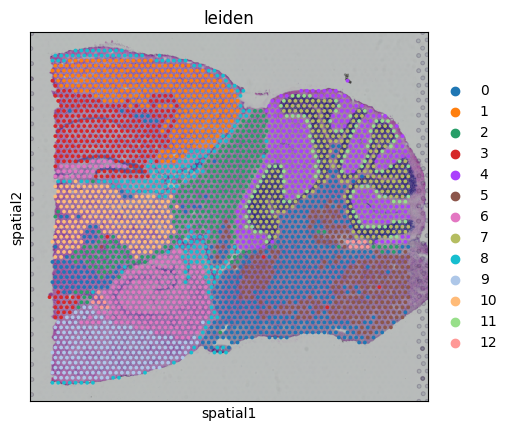

In [5]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.4)
sc.pl.spatial(adata, color='leiden')

## **Spatial communication inference**

We will use the CellChatDB ligand-receptor database here. Only the secreted signaling LR pairs will be used. 

Jin, Suoqin, et al. "Inference and analysis of cell-cell communication using CellChat." Nature communications 12.1 (2021): 1-20.

In [6]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type='Secreted Signaling', database='CellChat')
print(df_cellchat.shape)

(1209, 4)


We then filter the LR pairs to keep only the pairs with both ligand and receptor expressed in at least 5% of the spots.

In [7]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0.05)
print(df_cellchat_filtered.shape)

(250, 4)


In [8]:
print(df_cellchat_filtered.head())

       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling


Now perform spatial communication inference for these 250 ligand-receptor pairs with a spatial distance limit of 500. CellChat database considers heteromeric units. The signaling results are stored as spot-by-spot matrices in the obsp slots. For example, the score for spot i signaling to spot j through the LR pair can be retrieved from `adata_dis500.obsp['commot-cellchat-Wnt4-Fzd4_Lrp6'][i,j]`.

In [9]:
ct.tl.spatial_communication(adata_dis500,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)

In [10]:
adata_dis500.write("./adata.h5ad")

Determine the spatial direction of a signaling pathway, for example, the PSAP pathway. The interpolated signaling directions for where the signals are sent by the spots and where the signals received by the spots are from are stored in `adata_dis500.obsm['commot_sender_vf-cellchat-PSAP']` and `adata_dis500.obsm['commot_receiver_vf-cellchat-PSAP']`, respectively.

<AxesSubplot:>

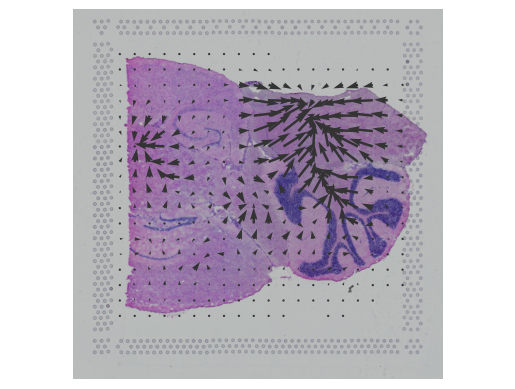

In [12]:
ct.tl.communication_direction(adata_dis500, database_name='cellchat', pathway_name='PSAP', k=5)
ct.pl.plot_cell_communication(adata_dis500, database_name='cellchat', pathway_name='PSAP', plot_method='grid', background_legend=True, 
    scale=0.00003, ndsize=8, grid_density=0.4, summary='sender', background='image', clustering='leiden', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)

Or summarize the signaling to the leiden clustering we generated at the beginning of this notebook. We did this also for the PSAP signaling pathway and the results are stored in `adata_dis500.uns['commot_cluster-leiden-cellchat-PSAP']`.

In [13]:
adata_dis500.obs['leiden'] = adata.obs['leiden']

In [14]:
ct.tl.cluster_communication(adata_dis500, database_name='cellchat', pathway_name='PSAP', clustering='leiden',
    n_permutations=100)

We can visualize the significant ones as networks with automatic node embedding.

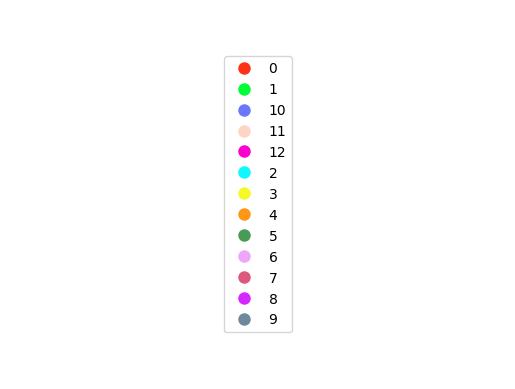

In [16]:
ct.pl.plot_cluster_communication_network(adata_dis500, uns_names=['commot_cluster-leiden-cellchat-PSAP'], 
    nx_node_pos=None, nx_bg_pos=False, p_value_cutoff = 5e-2, filename='PSAP_cluster.pdf', nx_node_cmap='Light24')

<div>
<img src="PSAP_cluster.jpg" width="700"/>
</div>

Or with spatial node embedding.

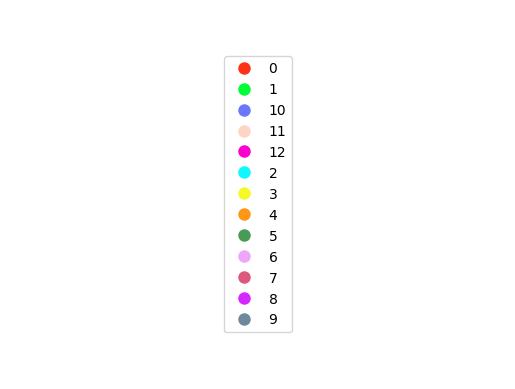

In [19]:
ct.tl.cluster_position(adata_dis500, clustering='leiden')
ct.pl.plot_cluster_communication_network(adata_dis500, uns_names=['commot_cluster-leiden-cellchat-PSAP'], clustering='leiden',
    nx_node_pos='cluster', nx_pos_idx=np.array([0, 1]), nx_bg_pos=True, nx_bg_ndsize=0.25, p_value_cutoff=5e-2,
    filename='PSAP_cluster_spatial.pdf', nx_node_cmap='Light24')

<div>
<img src="PSAP_cluster_spatial.jpg" width="400"/>
</div>

## **Downstream analysis**

**Identify signaling DE genes**

Now we further examine what genes are likely differentially expressed with respect to the inferred signaling activity. tradeSeq will be used to model the DE genes. This analysis is similar to finding temporal DE genes just with the pseudotime variable replaced by the amount of received signal. Count data is needed in `adata_dis500.layers['counts']`

Van den Berge, Koen, et al. "Trajectory-based differential expression analysis for single-cell sequencing data." Nature communications 11.1 (2020): 1-13.

In [20]:
adata_dis500 = sc.read_h5ad("./adata.h5ad")
adata = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Posterior')
adata_dis500.layers['counts'] = adata.X

Look for genes that are differentially expressed with respect to PSAP signaling.

In [27]:
df_deg, df_yhat = ct.tl.communication_deg_detection(adata_dis500, 
    database_name = 'cellchat', pathway_name='PSAP', summary = 'receiver')

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04m 47s       |+                                                 | 2 % ~04m 19s       |++                                                | 3 % ~04m 04s       |++                                                | 4 % ~03m 56s       |+++                                               | 5 % ~03m 49s       |+++                                               | 6 % ~03m 46s       |++++                                              | 7 % ~03m 44s       |++++                                              | 8 % ~03m 48s       |+++++                                             | 9 % ~03m 44s       |+++++                                             | 10% ~03m 41s       |++++++                                            | 11% ~03m 37s       |++++++                                            | 12% ~03m 36s       |+++++++                                           | 13% ~03m 

In [28]:
import pickle
deg_result = {"df_deg": df_deg, "df_yhat": df_yhat}
with open('./deg_PSAP.pkl', 'wb') as handle:
    pickle.dump(deg_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

Cluster the downstream genes and visualize the expression trends with respect to increased level of received signal through PSAP pathway (horizontal axis).

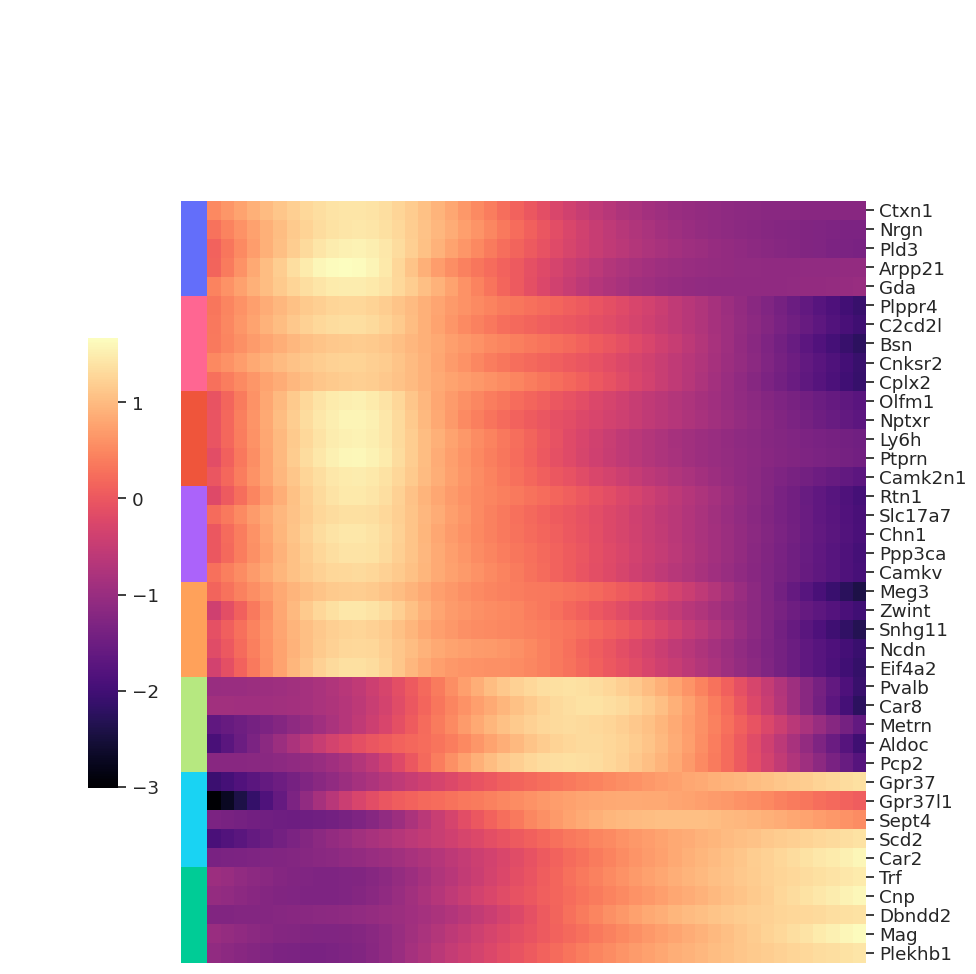

In [29]:
with open("./deg_PSAP.pkl", 'rb') as file:
    deg_result = pickle.load(file)
df_deg_clus, df_yhat_clus = ct.tl.communication_deg_clustering(df_deg, df_yhat, deg_clustering_res=0.4)
top_de_genes_PSAP = ct.pl.plot_communication_dependent_genes(df_deg_clus, df_yhat_clus, top_ngene_per_cluster=5,
    filename='./heatmap_deg_PSAP.pdf', font_scale=1.2, return_genes=True)

Plot some example signaling DE genes.

Text(0.5, 1.0, 'An example positive DE gene (Gpr37)')

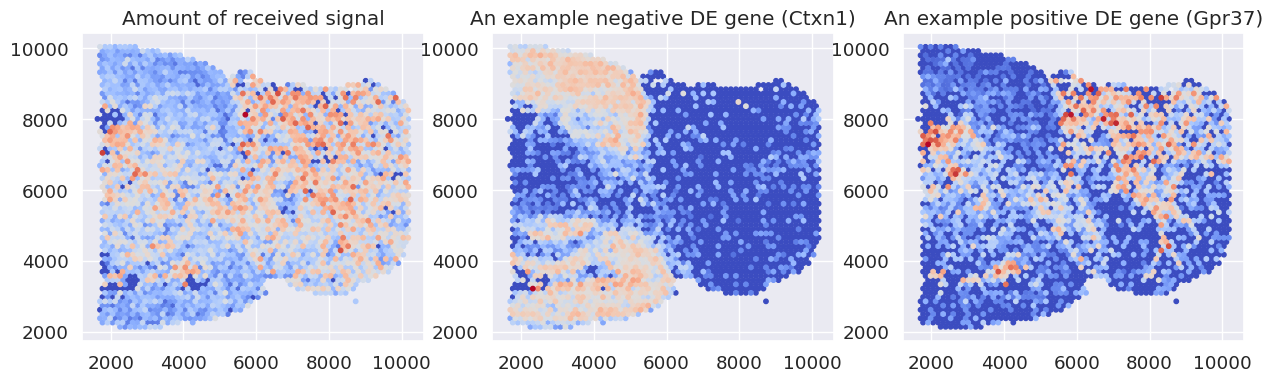

In [30]:
X_sc = adata_dis500.obsm['spatial']
fig, ax = plt.subplots(1,3, figsize=(15,4))
colors = adata_dis500.obsm['commot-cellchat-sum-receiver']['r-PSAP'].values
idx = np.argsort(colors)
ax[0].scatter(X_sc[idx,0],X_sc[idx,1], c=colors[idx], cmap='coolwarm', s=10)
colors = adata_dis500[:,'Ctxn1'].X.toarray().flatten()
idx = np.argsort(colors)
ax[1].scatter(X_sc[idx,0],X_sc[idx,1], c=colors[idx], cmap='coolwarm', s=10)
colors = adata_dis500[:,'Gpr37'].X.toarray().flatten()
idx = np.argsort(colors)
ax[2].scatter(X_sc[idx,0],X_sc[idx,1], c=colors[idx], cmap='coolwarm', s=10)
ax[0].set_title('Amount of received signal')
ax[1].set_title('An example negative DE gene (Ctxn1)')
ax[2].set_title('An example positive DE gene (Gpr37)')

**Further quantify impact of signaling on the DE genes**

The DE analysis above shows correlation between signaling and downstream gene expression. 
Now we further build random forest models with potential DE genes as targets and signaling as input and quantify the impact of signaling by feature importances. \
In each of the model, a gene from `top_de_genes_PSAP` is taken as the prediction target. The level of received signal through the PSAP pathway and a set of "background genes" are taken as the input features. The genes that have the highest correlation to the prediction target are used as "background genes". The feature importance of the received signal in the model reflects the impact on the target gene by this signaling considering the impact of other related genes.

In [31]:
df_impact_PSAP = ct.tl.communication_impact(adata_dis500, database_name='cellchat', pathway_name = 'PSAP',\
    tree_combined = True, method = 'treebased_score', tree_ntrees=100, tree_repeat = 100, tree_method = 'rf', \
    ds_genes = top_de_genes_PSAP, bg_genes = 500, normalize=True)

6 41
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


Visualize the impact scores as a heatmap. Here we only have two LR pairs in PSAP and we show the top 30 DE genes.

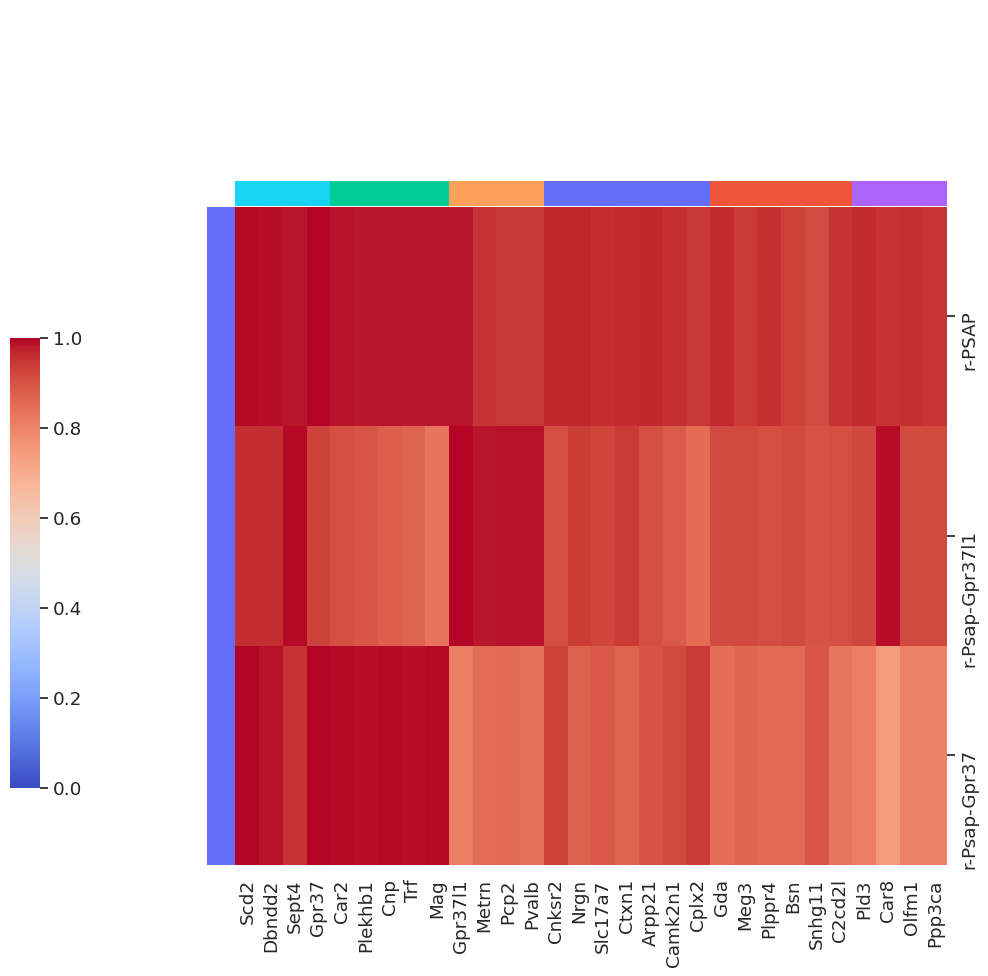

In [32]:
ct.pl.plot_communication_impact(df_impact_PSAP, summary = 'receiver', top_ngene= 30, top_ncomm = 5, colormap='coolwarm', 
    font_scale=1.2, linewidth=0, show_gene_names=True, show_comm_names=True, cluster_knn=2,
    filename = 'heatmap_impact_PSAP.pdf')

In [33]:
df_impact_PSAP

,Ctxn1,Nrgn,Pld3,Arpp21,Gda,Plppr4,C2cd2l,Bsn,Cnksr2,Cplx2,...,Gpr37l1,Sept4,Scd2,Car2,Trf,Cnp,Dbndd2,Mag,Plekhb1,average
s-Psap-Gpr37l1,0.967449,0.965943,0.968502,0.949332,0.972611,0.945425,0.946154,0.956802,0.954178,0.893866,...,0.994089,0.987955,0.923563,0.929615,0.918114,0.919514,0.943340,0.928519,0.939717,0.954271
s-Psap-Gpr37,0.940789,0.947870,0.919393,0.969150,0.938077,0.934150,0.940526,0.942045,0.969290,0.974211,...,0.908462,0.956984,0.974028,0.996802,0.995375,0.995000,0.993684,0.996856,0.995951,0.939856
s-PSAP,0.991964,0.991886,0.993603,0.994109,0.993138,0.987794,0.990607,0.986377,0.990669,0.978543,...,0.960405,0.985061,0.991296,0.983219,0.981075,0.980810,0.984960,0.978458,0.985081,0.977618
r-Psap-Gpr37l1,0.938219,0.936957,0.920891,0.904636,0.916457,0.909838,0.907409,0.916174,0.905497,0.853360,...,0.999251,0.992955,0.960263,0.903340,0.867566,0.877004,0.959008,0.832961,0.892085,0.921992
r-Psap-Gpr37,0.870506,0.874828,0.810567,0.897409,0.845081,0.851923,0.830486,0.857976,0.932860,0.938462,...,0.810972,0.950830,0.996640,0.994170,0.992150,0.992530,0.987874,0.994564,0.991802,0.778070
r-PSAP,0.963725,0.968438,0.962146,0.967227,0.961599,0.954595,0.949696,0.930425,0.966288,0.944474,...,0.981032,0.981296,0.992571,0.985243,0.983063,0.984049,0.990243,0.982333,0.982045,0.855133
